# XGBoost in Python, From Start to Finish (Credit Default)

----



-----

In [41]:
import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report # creates and draws a confusion matrix

----

<a id="download-the-data"></a>
# Import the data
Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.
Specifically, we are going to use the **[Credit Card Default](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)** dataset. This dataset will allow us to predict if someone will default on their credit card payments based on their sex, age and a variety of other metrics.

**NOTE:** When **pandas** (**pd**) reads in data, it returns a **data frame**, which is a lot like a spreadsheet. The data are organized in rows and columns and each row can contain a mixture of text and numbers. The standard variable name for a **data frame** is the initials **df**, and that is what we will use here:

In [11]:
source = 'https://raw.githubusercontent.com/nparis87/MachineLearning/main/CreditQuality.csv'

data = pd.read_csv(source, sep=';')

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the `head()` function:

Also, the values in the **ID** column were randomly assigned, making it uninformative, so we can drop it...

In [17]:
#data.drop('ID', axis=1, inplace=True) ## set axis=0 to remove rows, axis=1 to remove columns
data.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,...,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21
0,11,6,34,43,1169,65,75,4,93,101,...,121,67,143,152,2,173,1,192,201,0
1,12,48,32,43,5951,61,73,2,92,101,...,121,22,143,152,1,173,1,191,201,1
2,14,12,34,46,2096,61,74,2,93,101,...,121,49,143,152,1,172,2,191,201,0
3,11,42,32,42,7882,61,74,2,93,103,...,122,45,143,153,1,173,2,191,201,0
4,11,24,33,40,4870,61,73,3,93,101,...,124,53,143,153,2,173,2,191,201,1



----

# Missing Data: Dealing With Missing Data, XGBoost Style

One thing that is relatively unique about **XGBoost** is that it determines default behavior for missing data. So all we have to do is identify missing values and make sure they are set to `0`.

However, before we do that, let's see how many rows are missing data. If it's a lot, then we might have a problem on our hands that is bigger than what **XGBoost** can deal with on its own. If it's not that many, we can just set them to `0`.

----

In [19]:
X = data.drop('Column21', axis=1).copy() # alternatively: X = df_no_missing.iloc[:,:-1]
X.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20
0,11,6,34,43,1169,65,75,4,93,101,4,121,67,143,152,2,173,1,192,201
1,12,48,32,43,5951,61,73,2,92,101,2,121,22,143,152,1,173,1,191,201
2,14,12,34,46,2096,61,74,2,93,101,3,121,49,143,152,1,172,2,191,201
3,11,42,32,42,7882,61,74,2,93,103,4,122,45,143,153,1,173,2,191,201
4,11,24,33,40,4870,61,73,3,93,101,4,124,53,143,153,2,173,2,191,201


In [21]:
y = data['Column21'].copy()
y.head()

0    0
1    1
2    0
3    0
4    1
Name: Column21, dtype: int64

Now that we have created **X**, which has the data we want to use to make predictions, and **y**, which has the data we want to predict, we are ready to continue formatting **X** so that it is suitable for making a model with **XGBoost**.

----

<a id="one-hot-encoding"></a>
# Format the Data Part 2: One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use to make, or predict, classifications, and `y`, which contains the known classifications in our training dataset, we need to take a closer look at the variables in `X`. The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **LIMIT_BAL**, The amount of available credit **Integer**
- **SEX**, **Category**
  - 1 = male
  - 2 = female
- **EDUCATION**, **Category**
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
- **MARRIAGE**, **Category**
  - 1 = Married
  - 2 = Single
  - 3 = Other
- **AGE**, **Integer**
- **PAY_**, When the last 6 bills were payed **Category**
  - -1 = Paid on time
  - 1 = Payment delayed by 1 month
  - 2 = Payment delayed by 2 months
  - ...
  - 8 = Payment delayed by 8 months
  - 9 = Payment delayed by 9 or more months
- **BILL_AMT**, What the last 6 bills were **Integer**
- **PAY_AMT**, How much the last payments were **Integer**
- **DEFAULT**, Whether or not a person defaulted on the next payment **CATEGORY**
  - 0 = Did not default
  - 1 = Defaulted
  
Now, just to review, let's look at the data types in `X` to remember how python is seeing the data right now.

-----


----

<a id="build-tree"></a>
# Build A Preliminary XGBoost Model
At long last, the data is correctly formatted for making an **XGBoost** model. Now we simply split the data into **training** and **testing** sets and build the model. However, first, let's observe that this data is imbalanced by dividing the number of people who defaulted, where `y = 1`, by the total number of people in the dataset. 

In [22]:
sum(y)/len(y)

0.3

So we see that only 22% of the people in the dataset defaulted. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who defaulted in both the **training** set and the **testing** set.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Now let's verify that using `stratify` worked as expected...

In [24]:
sum(y_train)/len(y_train)

0.3

In [25]:
sum(y_test)/len(y_test)

0.3

In [31]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            seed=42)
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)

OK, we've built an **XGBoost** model for classification. Let's see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the model and drawing a **Confusion Matrix**.

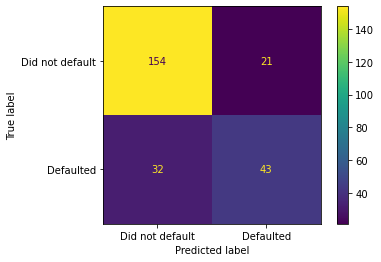

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did not default", "Defaulted"])
disp.plot()

In the confusion matrix, we see that of the **5841** people that did not default, **5491 (94%)** were correctly classified. So that's good. However, of the **1659** people that defaulted, only **619 (37%)** were correctly classified. So the **XGBoost** model was not awesome. Part of the problem is that our data is imbalanced, which we saw earlier and we see this in the confusion matrix with the top row showing **5841** people that did not default and the bottom row showing **1659** people who did. Because defaulting on loans costs the company a lot of money, we would like to capture more of the people that defaulted. The good news is that **XGBoost** has a parameter that helps with imbalanced data, So let's try to improve predictions using **Cross Validation** to optimize the parameters.

----

In [42]:
print(classification_report(y_test, y_pred,target_names=["Did not default", "Defaulted"]))

                 precision    recall  f1-score   support

Did not default       0.83      0.88      0.85       175
      Defaulted       0.67      0.57      0.62        75

       accuracy                           0.79       250
      macro avg       0.75      0.73      0.74       250
   weighted avg       0.78      0.79      0.78       250



So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=0`, `learning_rate=0.1`, `max_depth=6`, `reg_lambda=500` and `scale_pos_weight=3`.

----

<a id="draw-tree"></a>
# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [ ]:
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=6,
                            reg_lambda=500,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            ## the next two arguments set up early stopping:
                            eval_metric='aucpr',
                            early_stopping_rounds=10)
                        
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            eval_set=[(X_test, y_test)])

Now let's draw another confusion matrix to see if the optimized **XGBoost** model does better.

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                                      X_test,
                                      y_test,
                                      values_format='d',
                                      display_labels=["Did not default", "Defaulted"])

We see that the optimized **XGBoost** model is now almost twice as good at correctly classifying people that defaulted. This was at the expense of incorrectly classifying people that did not default, and this tradeoff is something that the company might have to think about. However, from our perspective, this was a success.

The last thing we are going to do is draw the first **XGBoost Tree** and discuss how to interpret it.

In [ ]:
## If we want to get information, like gain and cover etc, at each node in the first tree, 
## we just build the first tree, otherwise we'll get the average over all of the trees.
clf_xgb = xgb.XGBClassifier(seed=42,
                            objective='binary:logistic',
                            gamma=0,
                            learning_rate=0.1,
                            max_depth=6,
                            reg_lambda=500,
                            scale_pos_weight=3,
                            subsample=0.9,
                            colsample_bytree=0.5,
                            n_estimators=1, ## We set this to 1 so we can get gain, cover etc.
                            )
clf_xgb.fit(X_train, y_train)

## now print out the weight, gain, cover etc. for the tree
## weight = number of times a feature is used in a branch or root across all trees
## gain = the average gain across all splits that the feature is used in
## cover = the average coverage across all splits a feature is used in
## total_gain = the total gain across all splits the feature is used in
## total_cover = the total coverage across all splits the feature is used in
## NOTE: Since we only built one tree, gain = total_gain and cover=total_cover
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
## NOTE: num_trees is NOT the number of trees to plot, but the specific tree you want to plot
## The default value is 0, but I'm setting it just to show it in action since it is
## counter-intuitive.
xgb.to_graphviz(clf_xgb, num_trees=0, 
                condition_node_params=node_params,
                leaf_node_params=leaf_params)
## if you want to save the figure...
# graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10", 
#                 condition_node_params=node_params,
#                 leaf_node_params=leaf_params) 
# graph_data.view(filename='xgboost_tree_credit_card') ## save as PDF

Now let's discuss how to interpret the **XGBoost Tree**.
In each node, we have:
- The variable (column name) and the threshold for splitting the observations. For example, in the tree's root, we use **PAY_2_2** to split the observations. All observations with **PAY_2_2 < 0.5** go to the **left** and all observations with **PAY_2_2 =< 0.5** go to the **right**.
- Each branch either says **yes** or **no** and some also say **missing**. 
 - **yes** and **no** refer to whether the threshold in the node above it is true or not. If so, then **yes**, if not, then **no**. 
 - **missing** is the default option if there is missing data.
- **leaf** tells us the output value for each leaf.

-----

# In conclusion we...

- **[Loaded the Data From a File](#download-the-data)**

- **[Identified and Dealt with Missing Data](#identify-and-deal-with-missing-data)**

- **[Formatted the Data for XGBoost using One-Hot Encoding](#one-hot-encoding)**

- **[Built an XGBoost Model for Classification](#build-tree)**

- **[Optimize the XGBoost Parameters with Cross Validation and GridSearch()](#prune-tree)**

- **[Built, Drew, Interpreted and Evaluated the Optimized XGBoost Model](#draw-tree)**

# TRIPLE BAM!!!